In [1115]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from tensorflow.keras.callbacks import Callback

In [1116]:
data = pd.read_csv("./data.csv")
print(data.head())


train_data = data[data["subject"] == 1]["shape_num"].to_numpy()

# Future - evalutate link variance and actual reaction time evolution
RT_train_data = data[data["subject"] == 1]["RT_trimmed"].to_numpy()

def gen_data(d):
    data = np.empty((0, 24))
    for index in d:
        # Create an array of zeros with length 24
        result_array = np.zeros(24)
        result_array[d[index] - 1] = 1
        data = np.vstack((data, result_array))
    return data

X_train_all = gen_data(train_data)

"""
Y train creation:
Each following X train element is prediction, with after tertiary being an array 
of all 0's representing no knowledge of the following triplet element
"""

y_train_all = X_train_all.copy()
y_train_all[:-1] = y_train_all[1:]


y_train_all[2::3] = np.zeros(
    (int(y_train_all.shape[0]/3), 24)
)


"""
Create training and test data
"""

X_train = X_train_all[:-24*1]
y_train = y_train_all[:-24*1]


X_test = X_train_all[576-(24*1):]
y_test = y_train_all[576-(24*1):]

"""
Shape training data for model input
"""

X_train = np.reshape(X_train, (-1, 24, 24))
X_test = np.reshape(X_test, (-1, 24, 24))

y_train = np.reshape(y_train, (-1, 24, 24))
y_test = np.reshape(y_test, (-1, 24, 24))

   subject         ave          sd  block  triplet  position  shape_num    RT  \
0        1  463.309028  298.476633      1        1         1          1  1121   
1        1  463.309028  298.476633      1        1         2          2   886   
2        1  463.309028  298.476633      1        1         3          3   837   
3        1  463.309028  298.476633      1        7         1         19   843   
4        1  463.309028  298.476633      1        7         2         20  1264   

    RT_trimmed  log_RT_trimmed  change?  block>12  block>18  block>6  \
0  1060.262293        6.966272        1     False     False    False   
1   886.000000        6.786717        0     False     False    False   
2   837.000000        6.729824        0     False     False    False   
3   843.000000        6.736967        0     False     False    False   
4  1060.262293        6.966272        1     False     False    False   

   1-avg(2,3)  log_1-avg(2,3) odd_even  
0         NaN             NaN        o 

## Build network wth GRU

In [1117]:
def build_network(learning_rate: float = 0.05):
      model = tf.keras.Sequential()
      model.add(tf.keras.Input(shape=(1,24)))
      #model.add(tf.keras.layers.SimpleRNN(units=64, return_sequences = True, activation = "tanh"))
      model.add(tf.keras.layers.GRU(units=64, return_sequences = True, activation = "tanh"))
      #model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=24, activation="softmax")))  # Output shape should match the number of features
      model.add(tf.keras.layers.Dense(units=24, activation = "softmax")) 
      loss = tf.keras.losses.CategoricalCrossentropy()
      model.compile(optimizer = \
         tf.keras.optimizers.Adam(learning_rate = learning_rate), loss = loss, metrics = ["accuracy"])	
      return model


In [1118]:
class PredictionsCallback(Callback):
    def __init__(self, X_test):
        self.X_test = X_test
        self.batch_predictions = np.array([])

    def on_batch_end(self, batch, logs=None):
        predictions = self.model.predict(self.X_test)
        # You can do something with the predictions here, like save them or print them
        self.batch_predictions = np.append(self.batch_predictions, predictions)
        print("Predictions after batch {}: {} :: shape: {}".format(batch, predictions, predictions.shape))


    def on_epoch_end(self, epoch, logs=None):
        predictions = self.model.predict(self.X_test)
        # You can do something with the predictions here, like save them or print them
        print("Predictions for epoch {}: {}".format(epoch, predictions))
        
    def get_predictions(self):
        return self.batch_predictions

def train_model():
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    
    # Initialize the custom callback with the test data
    predictions_callback = PredictionsCallback(X_test)
    
    
    res = model.fit(X_train, y_train, epochs=1, batch_size=1, verbose=1, callbacks=[predictions_callback])

    
    print(res)
    return (res, predictions_callback.get_predictions())


In [1119]:
def show_res(res, verbose: bool = False):
    if verbose:
        print(res.history)
    fig, axs = plt.subplots(2,2)
    axs[0, 0].set_title("training loss")
    axs[0, 0].plot(res.history["loss"])
    axs[0, 1].set_title("training accuracy")
    axs[0, 1].plot(res.history["accuracy"])
    axs[1, 0].set_title("test loss")
    #axs[1, 0].plot(res.history["val_loss"])
    axs[1, 1].set_title("test accuracy")
    #axs[1, 1].plot(res.history["val_accuracy"])
    plt.show()

(23, 24, 24) (23, 24, 24) (1, 24, 24) (1, 24, 24)
 1/23 [>.............................] - ETA: 9s - loss: 2.1322 - accuracy: 0.0417WARNING:tensorflow:Model was constructed with shape (None, 1, 24) for input KerasTensor(type_spec=TensorSpec(shape=(None, 1, 24), dtype=tf.float32, name='input_93'), name='input_93', description="created by layer 'input_93'"), but it was called on an input with incompatible shape (None, 24, 24).
Predictions after batch 0: [[[0.03639675 0.03219099 0.05966551 0.03596617 0.0312991  0.03744895
   0.05485189 0.03779186 0.02825118 0.04205184 0.05446511 0.0403345
   0.05068279 0.03463461 0.04996495 0.05436867 0.04339495 0.03392209
   0.04365009 0.0347225  0.03012169 0.04800476 0.03582179 0.04999726]
  [0.04153749 0.03111645 0.03251557 0.03227367 0.04448009 0.03761914
   0.03566255 0.04675604 0.02337071 0.03338545 0.03437983 0.04566659
   0.0534579  0.07120125 0.02728085 0.03547375 0.04447582 0.02473648
   0.08667973 0.03607717 0.03531412 0.03691289 0.0603943  0.0

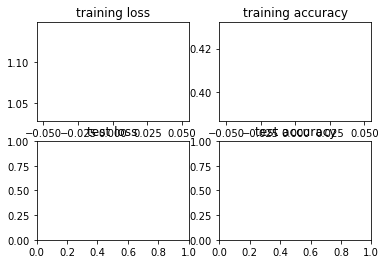

In [1120]:
model = build_network()
res, pred_per_batch = train_model()
model.summary()

show_res(res)

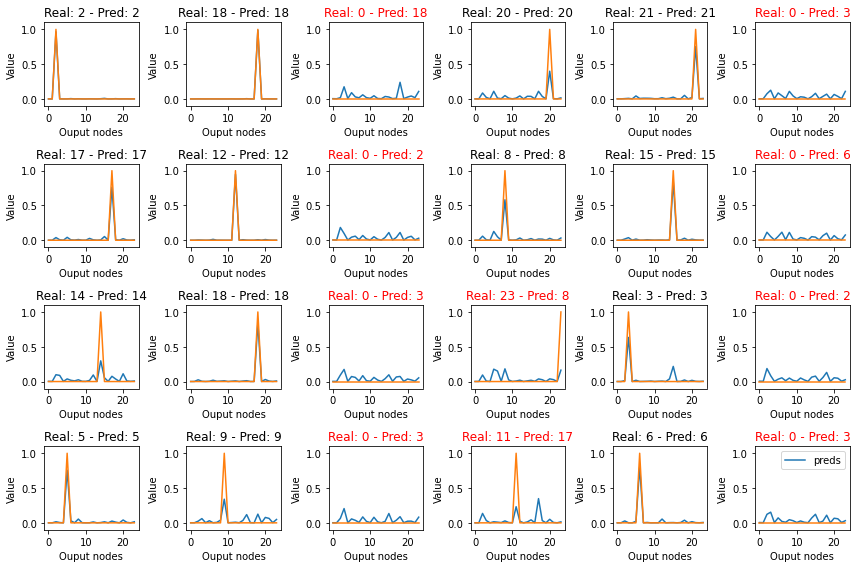

In [1121]:
pred = model.predict(X_test)

# Create 24 subplots
fig, axes = plt.subplots(4, 6, figsize=(12, 8))

variances = np.empty(24)

for i, ax in enumerate(axes.flatten()):
    ax.plot(pred[0, i, :], label="preds")
    ax.plot(y_test[0, i, :])
    ax.set_xlabel('Ouput nodes')
    ax.set_ylabel('Value')
    ax.set_ylim([-0.1, 1.1])
    ax.set_title(
    f'Real: {np.argmax(y_test[0, i])} - Pred: {np.argmax(pred[0, i, :])}',
    color='{kleur}'.format(kleur="black" if np.argmax(y_test[0, i]) == np.argmax(pred[0, i, :]) else "red")
    )
    variances[i] = np.var(pred[0, i, :])

plt.tight_layout()
plt.legend()
plt.show()

### Stronger predictions in late triplet component
More evident with increased epochs (ie 10 instead of 1)
Higher value (variance) meaning "faster" as more differentation is present

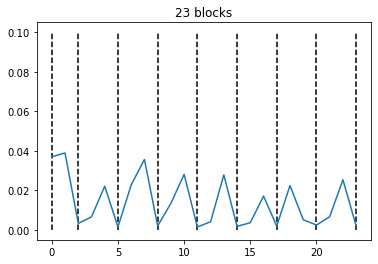

In [1122]:
plt.plot(variances)
plt.title("23 blocks")
triplets = [0,2,5,8,11,14,17,20,23]
plt.vlines(triplets, ymin=0.0, ymax=0.1, color="black", linestyle="--")
plt.show()


{'name': 'simple_rnn_1', 'trainable': True, 'dtype': 'float32', 'return_sequences': True, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'time_major': False, 'units': 64, 'activation': 'tanh', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'recurrent_initializer': {'class_name': 'Orthogonal', 'config': {'gain': 1.0, 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'recurrent_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'recurrent_constraint': None, 'bias_constraint': None, 'dropout': 0.0, 'recurrent_dropout': 0.0}
{'name': 'dense_92', 'trainable': True, 'dtype': 'float32', 'units': 24, 'activation': 'softmax', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': Non

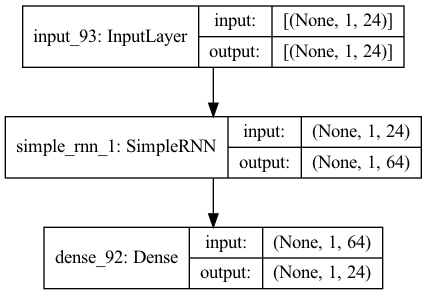

In [1123]:
for layer in model.layers: 
    #print(layer.get_config(), layer.get_weights())
    print(layer.get_config())
    #print(np.array(layer.get_weights()))
    
# pydot and graphviz required voor plot
tf.keras.utils.plot_model(model, to_file="model_plot.png", show_shapes=True, show_layer_names=True)

### Online measure

Showing that variability increases between activation/prediction in increasingly more blocks

(23, 24, 24)
means (23, 24)
means (23, 24)


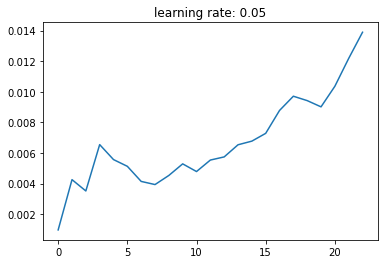

In [1124]:
#print(pred_per_batch)
pred_per_batch = np.reshape(pred_per_batch, (-1, 24, 24))
print(pred_per_batch.shape)
#print(pred_per_batch[0])

means = np.mean(pred_per_batch, axis=2)
vars = np.var(pred_per_batch, axis=2)
print("means", means.shape)
print("means", vars.shape)


#plt.plot(np.var(means, axis=1))
plt.title("learning rate: 0.05")
plt.plot(np.mean(vars, axis=1))
#print("var;", np.var(pred_per_batch, axis=1))
#print("var;", np.var(pred_per_batch, axis=1).size)
plt.show()